In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm
from uncertainties import unumpy

# Generate cusp trajectories

In [2]:
def simulate_cusp_traj(N_p, N_loop, N_t, ntau, s, dt, border, cusp_force):
    pos = np.empty((N_loop,N_p,N_t))
    vel = s*np.random.randn(N_loop,N_p,N_t)*1/np.sqrt(dt)

    pos[:,:,:ntau+1] = -border
    vel[:,:,:ntau+1] = 0

    for i in range(ntau+1,N_t):
        pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt
        vel[:,:,i] += cusp_force(pos[:,:,i-ntau], border)
    return pos

def get_abs_rate(pos,dt):
    N_p = pos.shape[1]
    pos_abs = pos.copy()
    for i in range(ntau+1, N_t):
        pos_abs[pos_abs[:,:,i] > 0,i:] = np.nan
    s_abs = np.sum(~np.isnan(pos_abs), axis=1)/N_p
    r_abs = -np.diff(np.log(s_abs), axis = 1)/dt
    return r_abs

def get_dist_rate(pos,dt):
    N_p = pos.shape[1]
    s_r = np.sum(pos < 0, axis = 1)/N_p
    s_l = np.sum(pos >= 0, axis = 1)/N_p
    r_dist = -np.diff(s_r)/(s_r[:,:-1]-s_l[:,:-1])/dt
    return r_dist

def get_min_min_rate(pos, dt):
    N_p = pos.shape[1]
    last_min = np.full(pos.shape,False, dtype = bool) #True is right and false is left
    for i in range(ntau+1,N_t):
        last_min[pos[:,:,i] > border,i:] = True
        last_min[pos[:,:,i] < -border,i:] = False
        
    s_lm = (1-np.sum(last_min, axis = 1)/N_p)
    left_to_right = np.sum( (last_min[:,:,:-1] == False) & (last_min[:,:,1:] == True), axis=1)/N_p
    r_lm = left_to_right/s_lm[:,1:]/dt
    return r_lm

In [19]:
N_p = 20_000
N_loop = 20

k = 3
tau = 0.3 #0.3
D = 1e-6
s = np.sqrt(2*D)
max_t = 5
dt = 1e-2
dx = 1e-5
border = 0.001

ntau = round(tau/dt)
ts = np.arange(0,max_t,dt)
ts_r = ts[1:]
x_s = np.arange(-0.004-dx/2,0.004+dx/2,dx)
bins = np.arange(-0.004-dx,0.004+dx,dx)

N_t = len(ts)
N_x = len(x_s)

s = np.sqrt(2*D)

def cusp_force(x,x_min):
    if x < 0:
        return -k*(x+x_min)
    else:
        return -k*(x-x_min)
cusp_force = np.vectorize(cusp_force)

## Use one show case

In [20]:
pos = simulate_cusp_traj(
    N_p = N_p,
    N_loop = N_loop,
    N_t = N_t,
    ntau = ntau,
    s = s,
    dt = dt,
    border = border, 
    cusp_force=cusp_force)

In [21]:
pos.shape

(20, 20000, 500)

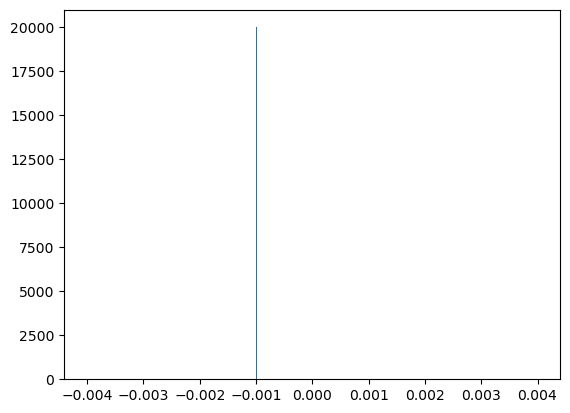

In [22]:
plt.hist(pos[2,:,20], bins = bins)
plt.show()

In [23]:
# Absorbing / first passage time
r_abs = get_abs_rate(pos,dt)
r_m_abs = np.mean(r_abs,axis  = 0)
r_std_abs = np.std(r_abs,axis=0)/np.sqrt(N_loop)

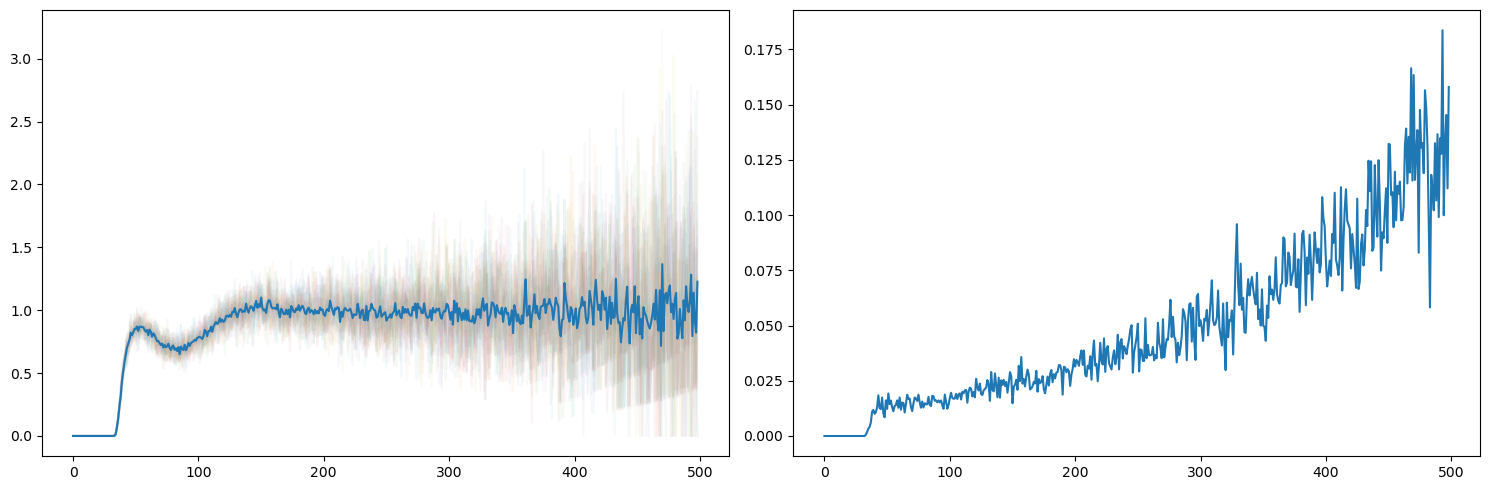

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(121)
for rate in r_abs:
    plt.plot(rate, alpha = 0.05)
plt.plot(r_m_abs)
plt.subplot(122)
plt.plot(r_std_abs)
plt.tight_layout()

In [25]:
# my dist rate funce
r_dist = get_dist_rate(pos,dt)
r_m_dist = np.mean(r_dist, axis = 0)
r_std_dist = np.std(r_dist,axis=0)/np.sqrt(N_loop)

/tmp/ipykernel_88016/4130026897.py:26: RuntimeWarning: divide by zero encountered in divide
  r_dist = -np.diff(s_r)/(s_r[:,:-1]-s_l[:,:-1])/dt


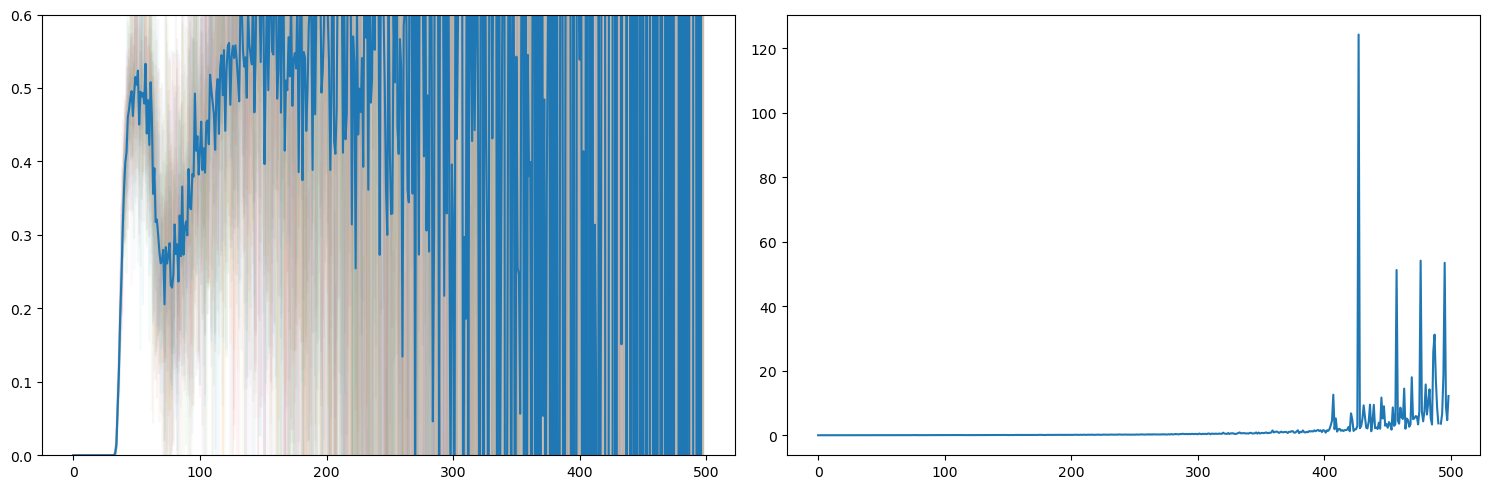

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(121)
for rate in r_dist:
    plt.plot(rate, alpha = 0.05)
plt.plot(r_m_dist)
plt.ylim(0,0.6)


plt.subplot(122)
plt.plot(r_std_dist)
plt.tight_layout()

In [27]:
# Min to min
r_lm = get_min_min_rate(pos, dt)

r_m_lm = np.mean(r_lm,axis  = 0)
r_std_lm = np.std(r_lm,axis=0)/np.sqrt(N_loop)

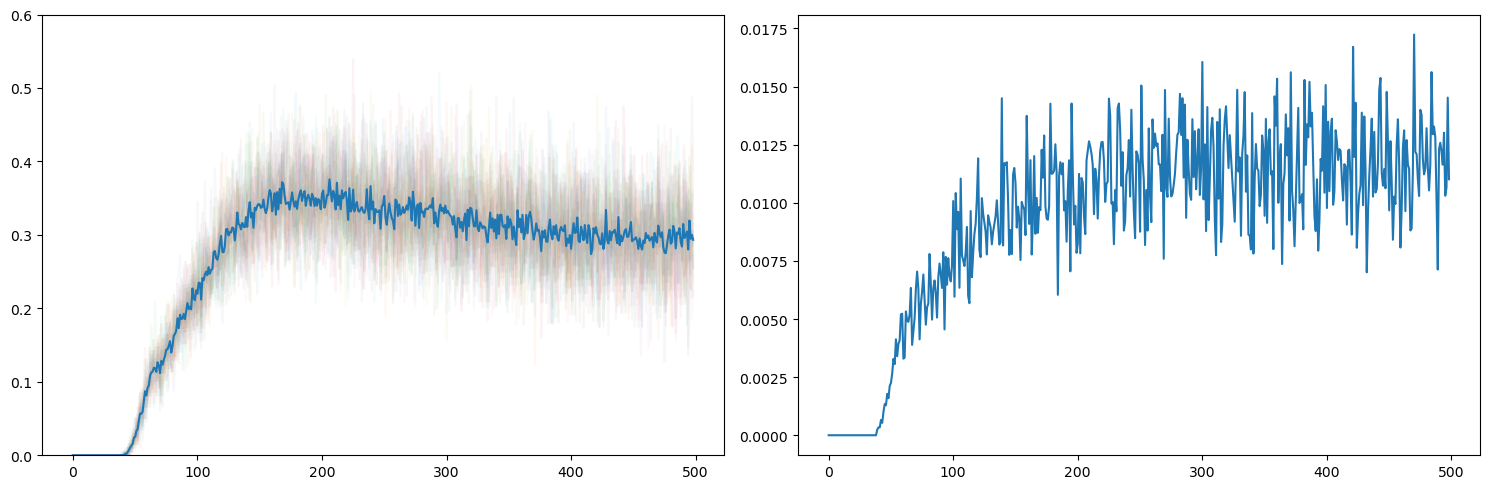

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(121)
for rate in r_lm:
    plt.plot(rate, alpha = 0.05)
plt.plot(r_m_lm)
plt.ylim(0,0.6)


plt.subplot(122)
plt.plot(r_std_lm)
plt.tight_layout()

In [29]:
# eq rates
avg_time = 200
def print_mean_uncert(array):
    print(f'{np.mean(array)} +/- {np.std(array)/np.sqrt(np.prod(array.shape))}')

print_mean_uncert(r_abs[:,-avg_time:])
print_mean_uncert(r_dist[:,-avg_time:])   
print_mean_uncert(r_lm[:,-avg_time:])

0.98970736829751 +/- 0.006636967152737337
-inf +/- nan
0.3043550570651009 +/- 0.0008609055442437777


# Inverstigate rate changes with changing tau

In [16]:
this_N_loop = 6
this_N_p = 10_000
this_taus = np.arange(0,0.8,0.05)
avg_time = 200

r_abs_ntaus = np.empty_like(this_taus)
r_dist_ntaus = np.empty_like(this_taus)
r_lm_ntaus = np.empty_like(this_taus)

r_abs_ntaus_stds = np.empty_like(this_taus)
r_dist_ntaus_stds = np.empty_like(this_taus)
r_lm_ntaus_stds = np.empty_like(this_taus)

for i,l_tau in enumerate(tqdm(this_taus)):
    l_ntau = round(l_tau/dt)
    
    pos =  simulate_cusp_traj(
    N_p = this_N_p,
    N_loop = this_N_loop,
    N_t = N_t,
    ntau = l_ntau,
    s = s,
    dt = dt,
    border = border, 
    cusp_force=cusp_force)
    
    o = get_abs_rate(pos,dt)[:,-avg_time:]
    r_abs_ntaus[i] = np.mean(o)
    r_abs_ntaus_stds[i] = np.std(o)/np.sqrt(np.prod(o.shape))
    
    
    o = get_dist_rate(pos,dt)[:,-avg_time:]
    r_dist_ntaus[i] = np.mean(o)
    r_dist_ntaus_stds[i] = np.std(o)/np.sqrt(np.prod(o.shape))
    
    o = get_min_min_rate(pos,dt)[:,-avg_time:]
    r_lm_ntaus[i] = np.mean(o)
    r_lm_ntaus_stds[i] = np.std(o)/np.sqrt(np.prod(o.shape))
    
    o = None

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_88016/4130026897.py:26: RuntimeWarning: divide by zero encountered in divide
  r_dist = -np.diff(s_r)/(s_r[:,:-1]-s_l[:,:-1])/dt
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/tmp/ipykernel_88016/4130026897.py:26: RuntimeWarning: invalid value encountered in divide
  r_dist = -np.diff(s_r)/(s_r[:,:-1]-s_l[:,:-1])/dt


(0.0, 1.5)

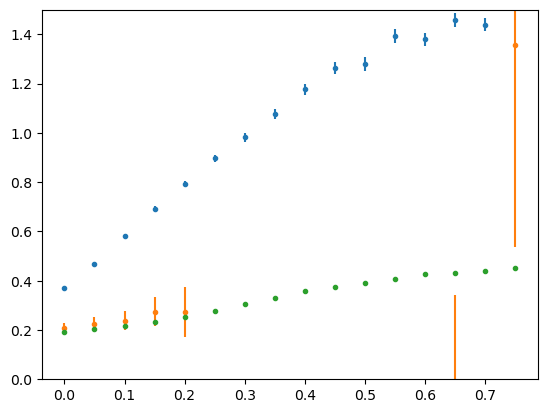

In [17]:
plt.errorbar(this_taus, r_abs_ntaus, r_abs_ntaus_stds, marker = '.', ls = 'None')
plt.errorbar(this_taus, r_dist_ntaus, r_dist_ntaus_stds, marker = '.', ls = 'None')
plt.errorbar(this_taus, r_lm_ntaus, r_lm_ntaus_stds, marker ='.', ls = 'None')
plt.ylim(0,1.5)

Text(0, 0.5, 'kappa / kappa')

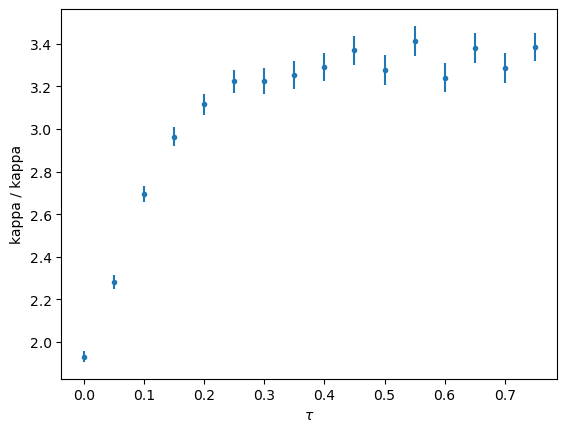

In [42]:
rate_ratio_u = unumpy.uarray(r_abs_ntaus, r_abs_ntaus_stds) / unumpy.uarray(r_lm_ntaus, r_lm_ntaus_stds)
plt.errorbar(this_taus,unumpy.nominal_values(rate_ratio_u), unumpy.std_devs(rate_ratio_u), marker = '.', ls ='none')
plt.xlabel(r'$\tau$')
plt.ylabel(r'kappa / kappa')

# Vicots method tau = 0

In [30]:
# cusp

R = np.zeros(( N_x, N_x))
data = np.zeros((N_t, N_x))
data[0,np.argmin((x_s+border)**2)] = 1


F = cusp_force(x_s, border)
Fm = (F[1:]+F[:-1])/2
rip = D / dx**2 * np.exp((Fm*dx/D)/2)  # r_i->i+1
rim = D / dx**2 * np.exp(-(Fm*dx/D)/2)  # r_i+1->i

R[0,0] = -rip[0]
R[-1,-1] = -rim[-1]
R[np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[1:]+rim[:-1]) # -(r_i->i+1 + r_i->i-1) ????
R[np.arange(0,N_x-1),np.arange(1,N_x)] = rim
R[np.arange(1,N_x),np.arange(0,N_x-1)] = rip

prop = expm(R*dt)

for i in range(1,N_t):
    data[i] = prop@data[i-1]


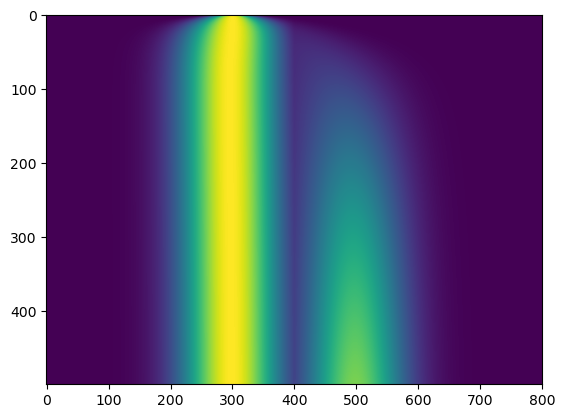

In [31]:
plt.imshow(data/data.max(axis=1)[:,None], aspect='auto')

In [32]:
s_l_ana = np.sum(data[:,x_s < 0], axis = 1)
s_r_ana = 1-s_l_ana

r_dist_ana = -np.diff(s_r_ana)/(s_r_ana[:-1]-s_l_ana[:-1])/dt

In [34]:
# absorbing

x_s_abs = x_s[x_s <= dx]
N_x_abs = len(x_s_abs)

R_abs = np.zeros(( N_x_abs, N_x_abs))
data_abs = np.zeros((N_t, N_x_abs))
data_abs[0,np.argmin((x_s_abs+border)**2)] = 1


F_abs = cusp_force(x_s_abs, border)
Fm_abs = (F_abs[1:]+F_abs[:-1])/2
rip_abs = D / dx**2 * np.exp((Fm_abs*dx/D)/2)  # r_i->i+1
rim_abs = D / dx**2 * np.exp(-(Fm_abs*dx/D)/2)  # r_i+1->i

R_abs[0,0] = -rip_abs[0]
R_abs[-1,-1] = -rim_abs[-1]
R_abs[np.arange(1,N_x_abs-1),np.arange(1,N_x_abs-1)] = -(rip_abs[1:]+rim_abs[:-1]) # -(r_i->i+1 + r_i->i-1) ????
R_abs[np.arange(0,N_x_abs-1),np.arange(1,N_x_abs)] = rim_abs
R_abs[np.arange(1,N_x_abs-1),np.arange(0,N_x_abs-2)] = rip_abs[:-1]

prop_abs = expm(R_abs*dt)

for i in range(1,N_t):
    data_abs[i] = prop_abs@data_abs[i-1]


suv_prob_abs = data_abs.sum(1)
num_kappa_abs = -np.diff(np.log(suv_prob_abs))/dt

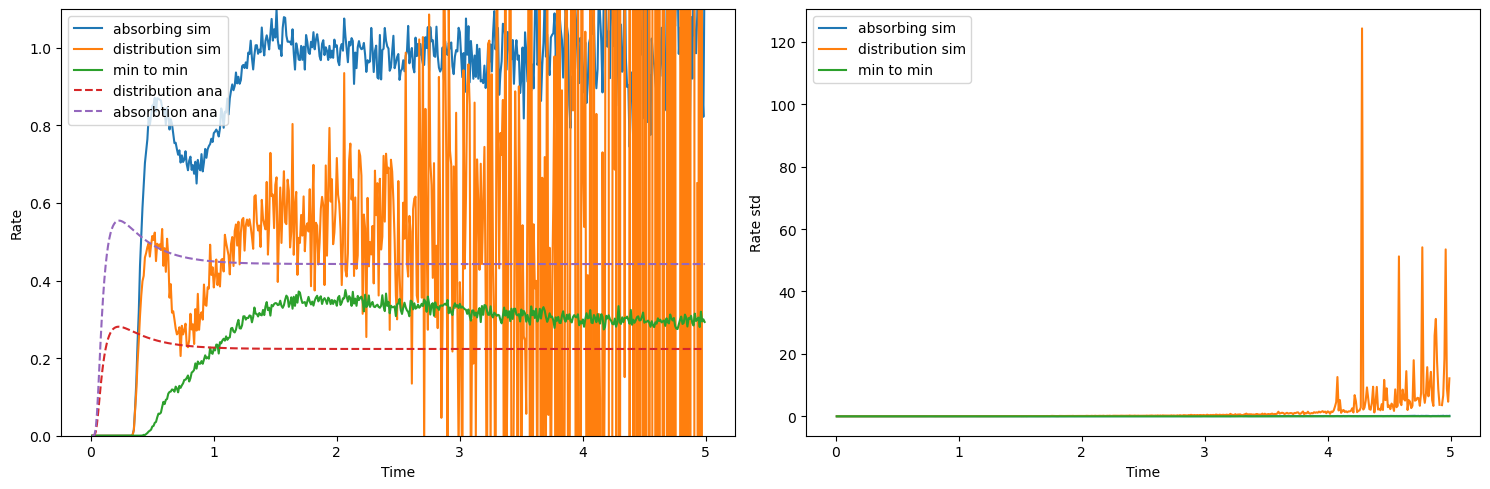

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(ts_r,r_m_abs, label='absorbing sim')
plt.plot(ts_r,r_m_dist, label='distribution sim')
plt.plot(ts_r,r_m_lm, label='min to min')
plt.plot(ts_r,r_dist_ana, ls = '--', label='distribution ana')
plt.plot(ts_r,num_kappa_abs, ls = '--', label = 'absorbtion ana')
plt.legend()
plt.ylim(-0,1.1)
plt.xlabel('Time')
plt.ylabel('Rate')


plt.subplot(122)
plt.plot(ts_r,r_std_abs,label='absorbing sim')
plt.plot(ts_r,r_std_dist,label='distribution sim')
plt.plot(ts_r,r_std_lm, label='min to min')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Rate std')
plt.tight_layout()

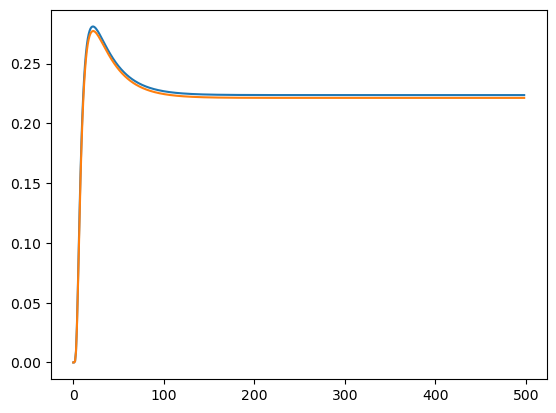

In [37]:
plt.plot(r_dist_ana)
plt.plot(num_kappa_abs/2)

In [ ]:
## 